In [1]:
import parseTrackletXML as xmlParser

kittiDir = '/home/cd/udacity_workspace/kitti2bag/raw_data_downloader/2011_09_26'
drive = '2011_09_26_drive_0001_sync'
tracklets = xmlParser.example(kittiDir, drive)

parsing tracklet file /home/cd/udacity_workspace/kitti2bag/raw_data_downloader/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets
tracklet   0: [Tracklet over 14 frames for Car]
tracklet   1: [Tracklet over 21 frames for Car]
tracklet   2: [Tracklet over 27 frames for Car]
tracklet   3: [Tracklet over 108 frames for Tram]
tracklet   4: [Tracklet over 34 frames for Car]
tracklet   5: [Tracklet over 29 frames for Car]
tracklet   6: [Tracklet over 32 frames for Car]
tracklet   7: [Tracklet over 37 frames for Car]
tracklet   8: [Tracklet over 36 frames for Car]
tracklet   9: [Tracklet over 47 frames for Car]
tracklet  10: [Tracklet over 75 frames for Cyclist]
tracklet  11: [Tracklet over 37 frames for Cyclist]
tracklet  12: [Tracklet over 23 frames for Car]
tracklet  13: [Tracklet over 37 frames for Car]
tracklet  14: [Tracklet over 15 frames for Car]


In [ ]:
for iTracklet, tracklet in enumerate(tracklets):
    print ('tracklet {0: 3d}: {1}'.format(iTracklet, tracklet) )
   
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
        # print (absoluteFrameNumber)        
        # end: for all frames
        pass
    #end: for all tracklets
    
# create a data frame that including all the tracelet


In [2]:
import numpy as np
import pandas as pd
df = pd.DataFrame( columns = ['frame_nr','object','tx', 'ty', 'tz','rz','height','width','length'])

for iTracklet, tracklet in enumerate(tracklets):
    # print ('tracklet {0: 3d}: {1}'.format(iTracklet, tracklet) )
   
    for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
        # print (absoluteFrameNumber)        
        # end: for all frames
        df.loc[len(df)]=[int(absoluteFrameNumber),tracklet.objectType, translation[0] , translation[1], translation[2], rotation[2], tracklet.size[0], tracklet.size[1],tracklet.size[2]] 
    #end: for all tracklets

# change type of frame 
df['frame_nr'] = df['frame_nr'].astype(int)


In [3]:
number_of_frame = np.amax(df.frame_nr)
print (number_of_frame)

107


In [ ]:
import cv2

number_of_frame = np.amax(df.frame_nr)
layer_nr = 2
prefix = '2011_09_26_drive_0001' 


for i in range(number_of_frame):
    df_frame_car = df[ ( (df.frame_nr == i) & (df.object == 'Car')) ]
    # create training label
    
    # draw bounding box on the image 
    name = './'+ 'rosws/train_data/'+ prefix + '_'+  str(i) + '_'+ str(layer_nr) + '.png'
    vis_name = './'+ 'rosws/train_data/'+ prefix + '_'+  str(i) + '_bb'+'.png'

    image = cv2.imread(name)
        
    # iterate data frame
    for index, row in df_frame_car.iterrows():
        # print (row.frame_nr, row.object)
        ( fl , fr, rr, rl) = compute_bb_pixel_coordinate( row.tx, row.ty, row.rz, row.width, row.length) 
        vetexes = np.array([fl , fr, rr, rl ],np.int32)
        cv2.polylines(image, np.int32([vetexes]), True, (0,255,0), 2)
        #cv2.rectangle(image, fl ,rr,(0,255,0),2)
    
    # save image
    print (vis_name)
    cv2.imwrite(vis_name, image)


In [4]:
df[ ( (df.frame_nr == 0) & (df.object == 'Car')) ]

,frame_nr,object,tx,ty,tz,rz,height,width,length
0,0,Car,25.212516,8.603392,-1.792157,-3.184200,2.167235,1.705712,4.329356
14,0,Car,33.648306,7.928600,-1.732406,3.070164,1.732879,1.601504,4.112924
35,0,Car,42.997023,7.207521,-1.493238,3.060272,1.465181,1.627679,4.110422
170,0,Car,49.766171,6.450322,-1.485013,3.042997,1.801963,1.605626,3.831222


In [5]:
df[ ( (df.frame_nr == 10) & (df.object == 'Car')) ]

,frame_nr,object,tx,ty,tz,rz,height,width,length
10,10,Car,11.739630,9.041578,-1.864243,-3.164222,2.167235,1.705712,4.329356
24,10,Car,20.133082,8.644599,-1.773585,3.092659,1.732879,1.601504,4.112924
45,10,Car,29.475826,8.164261,-1.613912,3.079196,1.465181,1.627679,4.110422
180,10,Car,36.281371,7.568980,-1.548274,3.072846,1.801963,1.605626,3.831222
206,10,Car,41.302402,7.120643,-1.556183,3.074440,1.445430,1.446091,3.399113
233,10,Car,46.079759,6.804262,-1.591918,3.061908,1.752060,1.713728,4.314772


In [6]:
def metric2pixel(x,y,resolution = 0.1, width_meter = 80, height_meter = 50 ):
    px = x / resolution +  width_meter/resolution / 2.0  ;
    py = -y / resolution +  height_meter/resolution / 2.0  ;
    return np.array([int(px), int(py)])

In [7]:
from math import cos
from math import sin

def compute_bb_pixel_coordinate ( tx, ty , rz, width, length ):
    # compute front left (fl) and rear right (rr) pt
    # transform velodye to car
    vTc_trans = np.array([[1,0,tx], [0,1,ty], [0, 0, 1] ]) 
    vTc_rot =   np.array([  [cos(rz), -sin(rz), 0], [sin(rz), cos(rz), 0 ] , [0, 0, 1] ]) 
    vTc = vTc_trans.dot(vTc_rot)
    
    p_flIncar =  np.array( [length / 2.0 ,  width/2.0, 1] )
    p_flInvelo =  vTc.dot(p_flIncar.transpose())
    
    p_frIncar =  np.array( [length / 2.0 , -width/2.0, 1])
    p_frInvelo =  vTc.dot(p_frIncar.transpose())

 
    p_rrIncar =  np.array( [-length / 2.0 , -width/2.0, 1])
    p_rrInvelo =  vTc.dot(p_rrIncar.transpose())

    p_rlIncar =  np.array( [-length / 2.0 , width/2.0, 1])
    p_rlnvelo =  vTc.dot(p_rlIncar.transpose())
 
    
    # now compute to pixel cooridnate
    fl = metric2pixel( p_flInvelo[0], p_flInvelo[1])
    fr = metric2pixel( p_frInvelo[0], p_frInvelo[1])
    rr = metric2pixel( p_rrInvelo[0], p_rrInvelo[1])
    rl = metric2pixel( p_rlnvelo[0], p_rlnvelo[1])
    return (fl, fr, rr, rl)



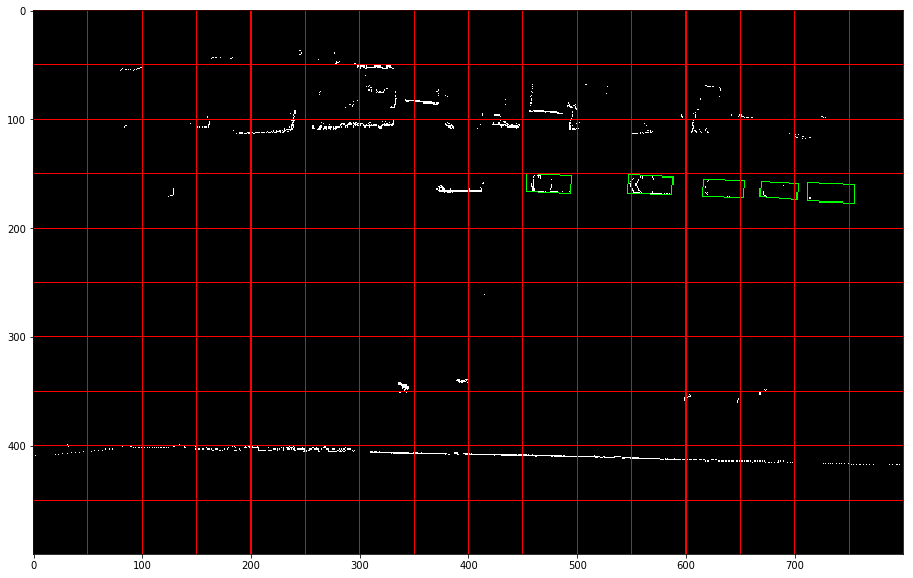

In [9]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

prefix = '2011_09_26_drive_0001' 
frame_nr = 20
layer_nr = 4
name = './'+ 'rosws/train_data/'+ prefix + '_'+  str(frame_nr) + '_'+ str(layer_nr) + '.png'
image = cv2.imread(name)
image.shape

df_frame_car = df[ ( (df.frame_nr == frame_nr) & (df.object == 'Car')) ]

for index, row in df_frame_car.iterrows():
        # print (row.frame_nr, row.object)
        ( fl , fr, rr, rl) = compute_bb_pixel_coordinate( row.tx, row.ty, row.rz, row.width, row.length) 
        vetexes = np.array([fl , fr, rr, rl ],np.int32)
        cv2.polylines(image, np.int32([vetexes]), True, (0,255,0), 1)
        #cv2.rectangle(image, fl ,rr,(0,255,0),2)

plt.figure(1, figsize=(50,10))

vlines = np.arange(0,500,50)
hlines = np.arange(0,800,50)

for v_pos in vlines:   
    cv2.line(image, (0, v_pos), (800, v_pos), (255,0,0))
for h_pos in hlines:   
    cv2.line(image, (h_pos, 0), (h_pos, 500), (255,0,0))
plt.imshow(image)
# cv2.imwrite('test.png', image)

 

In [ ]:
vlines = np.arange(100,500,100)
hlines = np.arange(100,800,100)

In [ ]:
hlines = np.arange(0,800,50)


In [ ]:
hlines

In [ ]:
# global parameter 
grid_resolution = 50 #pixel 
image_width = 800  #pixel
image_height = 500 #pixel
h_grid_nr = int (image_width / grid_resolution)
v_grid_nr = int (image_height / grid_resolution)

# s: condidence, tx, ty , rz, width, length
print('label shape {0:2d} x {1:2d} x 6'.format(h_grid_nr,v_grid_nr ))
label = np.zeros([h_grid_nr, v_grid_nr , 6])

In [ ]:
def create_training_label(df_car):
    label =  np.zeros([h_grid_nr, v_grid_nr , 6])
    for index, row in df_car.iterrows():
        # print (row.frame_nr, row.object)
        #( fl , fr, rr, rl) = compute_bb_pixel_coordinate( row.tx, row.ty, row.rz, row.width, row.length) 
        car_center_pixel = metric2pixel( row.tx, row.ty)
        # only consider pixel in image range
        if car_center_pixel[0] < image_width and car_center_pixel[1] < image_height:       
            print (car_center_pixel)
            x = int(np.ceil( car_center_pixel[0] / grid_resolution ) - 1 )
            y = int(np.ceil( car_center_pixel[1] / grid_resolution ) - 1 )
            # x y is the position of grid
            # set confidence
            label[x][y][0] = 1.0
            # set normalized tx 
            label[x][y][1] = car_center_pixel[0] / grid_resolution - x 
            label[x][y][2] = car_center_pixel[1] / grid_resolution - y 
            label[x][y][3] = (row.rz + np.pi) / (2 * np.pi)
            label[x][y][4] = row.width / 5
            label[x][y][5] = row.length / 5
            # print(x,y)
            # print (label[x][y])
    return label
            

In [ ]:
y_train = create_training_label(df_frame_car)
y_train.shape
y_train.flatten


In [ ]:
# training number 
train_nr = 1 
layer_nr = 8
train = np.zeros( [train_nr, image_height, image_width, layer_nr])
train.shape
# fill in training data
for i in range(layer_nr):
    name = './'+ 'rosws/train_data/'+ prefix + '_'+  str(frame_nr) + '_'+ str(i) + '.png'
    image = cv2.imread(name)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # crop all the left part
    gray_image[0:int(image_height), 0:int(image_width/2)] = gray_image[0:int(image_height), 0:int(image_width/2)] * 0.0
    gray_image = gray_image/255.0
    train[0,:,:,i] =  gray_image



In [ ]:
print (train.shape)
y_label = np.zeros([1,960])
y_label[0] = y_train.flatten()
print (y_label.shape)
print (train.shape)

y_train[9,3,:]

test = y_label * y_label
print (test.shape)

weight_mat = np.zeros(y_label.shape)
weight_mat.shape
weight_mat = np.zeros([h_grid_nr, v_grid_nr , 6] )
for i in range(h_grid_nr):
    for j in range(v_grid_nr):
        weight_mat[i,j,:] = [5,0.5,0.5,0.5,0.5,0.5]

flattened_weight_mat = weight_mat.flatten()
print (y_label)

In [ ]:
from keras import backend as K

def custom_loss(y_true, y_pred):
    '''Just another crossentropy'''
    #y_pred = T.clip(y_pred, epsilon, 1.0 - epsilon)
    #y_pred /= y_pred.sum(axis=-1, keepdims=True)
    #cce = T.nnet.categorical_crossentropy(y_pred, y_true)
  
    return K.mean(  (y_true - y_pred) * (y_true - y_pred) * flattened_weight_mat )

In [ ]:
# define network architecture 
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense , Lambda, MaxPooling2D, Dropout,Cropping2D
from keras.optimizers import Adam

model = Sequential()
# conv_net
model.add(Conv2D( 24, 5, 5, input_shape=(500, 800, 8), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D( 36, 5, 5,  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D( 48, 5, 5,  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(2048))
model.add(Dense(960))
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=custom_loss)
model.summary()

model.fit(train, y_label, batch_size=1 ,nb_epoch= 100, verbose=1)
# model.fit_generator(train_generator, samples_per_epoch= 3 * len(train_samples), validation_data=validation_generator, nb_val_samples=3 * len(validation_samples), nb_epoch=5)
# model.save('nvidia_model.h5')
